In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade gensim

     ---------------------------------------- 24.0/24.0 MB 2.7 MB/s eta 0:00:00
     -------------------------------------- 986.3/986.3 kB 9.0 MB/s eta 0:00:00
     ---------------------------------------- 67.1/67.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20448 sha256=85b6da9bf6e055ecca5b85e7337c94250288a648652a46af7b36abbd2b2ebebd
  Stored in directory: c:\users\aldoc\appdata\local\pip\cache\wheels\99\66\48\d7ce0c6927f6abf167bbcdee537affc7b92c03632f78028411
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3522 sha256=b108a19fd908b571a5a39f093da481bb61cfafd24714a5c650a7581707a4a6c7
  Stored in directory: c:\users\aldoc\appdata\local\pip\cache\wheels\d9\c7\71\db1d4646d963b34c530667501d3d6f34c0825eaffae2f0

In [1]:
import pandas as pd
import gensim
from gensim.models import Word2Vec 
import gensim.downloader

from TweetNormalize import normalizeTweet

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# we upload the dataset

df = pd.read_csv('../data_sets/all_annotated_tweets_update.csv') 

In [3]:
for i in df.index:
    df['text'][i] = normalizeTweet(df['text'][i])            # we transfor each mention in '@USER', each url in 'HTTPURL'
    df['text'][i] = df['text'][i].replace('@USER', '')       # and the emoji in string. Then, delete both '@USER' and 'HTTPURL'
    df['text'][i] = df['text'][i].replace('HTTPURL', '')
    df['text'][i] = df['text'][i].lstrip()

In [4]:
dataframes = {}

for occupation in set(df['occupation']):
    dataframes[occupation] = df[df['occupation'] == occupation]

In [5]:
# tweet preprocessing: tokenization, lemmatization, removal of stop words, named entities, punctuation marks, numbers and tokens
# shorter than 2 characters

nlp = spacy.load('en_core_web_sm')

for key, df_ in dataframes.items():
    tokenized = []

    for i in df_['text']:
        text_data = i
        doc = nlp(text_data)             
        tokens = [token.lemma_ for token in doc if not token.is_stop and not token.ent_type_ 
                  and not token.is_punct and not token.like_num]
        tokens = [tok.lower() for tok in tokens if len(tok) > 1]
        tokenized.append(tokens)
        
    dataframes[key] = tokenized      

In [6]:
# dataframes is a dictionary that has the professions as keys and a lists of tokenized tweets as values

# dataframes

In [7]:
# compute bigrams and trigrams
from gensim.models import Phrases

# add bigrams and trigrams to dataframes['occupation'] if they appear at least twice among the tweets of each occupation
for key, df_ in dataframes.items():
    bigram = Phrases(df_, min_count=2)
    trigram = Phrases(bigram[df_], min_count=2)
    for i in range(len(df_)):
        for token in bigram[df_[i]]:
            if token.count('_') == 1:
                df_[i].append(token)
        for token in trigram[bigram[df_[i]]]:
            if token.count('_') == 2:
                df_[i].append(token)

In [8]:
# create a dictionary that has the professions as keys and the dictionary representations of tweets per occupation as values

from gensim.corpora import Dictionary

dicts = {}

for key, df_ in dataframes.items():
    d = Dictionary(df_)
    dicts[key] = d

In [9]:
for k, d in dicts.items():
    print(k, "-->", len(d))

sci_cul --> 594
arts --> 542
show --> 603
sport --> 663
pol_act --> 832


In [10]:
# filter out words that occur less than 5 documents, or more than 50% of the documents.

for d in dicts.values():
    d.filter_extremes(no_below=5, no_above=0.5)

In [11]:
for k, d in dicts.items():
    print(k, "-->", len(d))

sci_cul --> 27
arts --> 35
show --> 32
sport --> 50
pol_act --> 52


In [12]:
# Create a dictionary that has the professions as keys and bag-of-words representations of tweets per occupation as values.

corpora = {}

for k in dataframes.keys():
    corpus = [dicts[k].doc2bow(tweet) for tweet in dataframes[k]]
    corpora[k] = corpus

In [13]:
# the number of tokens and documents we have to train on

for k in dicts.keys():
    print(k)
    print('Number of unique tokens: %d' % len(dicts[k]))
    print('Number of documents: %d' % len(corpora[k]))

sci_cul
Number of unique tokens: 27
Number of documents: 157
arts
Number of unique tokens: 35
Number of documents: 151
show
Number of unique tokens: 32
Number of documents: 152
sport
Number of unique tokens: 50
Number of documents: 243
pol_act
Number of unique tokens: 52
Number of documents: 255


### Training

In [14]:
from gensim.models import LdaModel

In [15]:
d_topics = {}

In [16]:
def train(dictionary, corpus, dic, k):
    
    # set training parameters
    num_topics = 3
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  

    temp = dictionary[0]
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )

    top_topics = model.top_topics(corpus)
    
    dic[k] = top_topics

In [17]:
for key in dataframes:
    train(dicts[key], corpora[key], d_topics, key)

In [18]:
for occ, topics in d_topics.items():
    print('\nTopic Modelling with respect to job field', occ, '\n')
    avg_topic_coherence = sum([t[1] for t in topics]) / len(topics)
    # compute Average topic coherence
    print('Average topic coherence: %.4f.' % avg_topic_coherence)
    for topic in topics:
        print()
        print (topic[1], [w[1] for w in topic[0]])


Topic Modelling with respect to job field sci_cul 

Average topic coherence: -13.6568.

-13.43403892677585 ['fuck', 'shit', 'cunt', 'like', 'right', 'fucking', 'oh', 'not', 'ass', 'stupid', 'know', 'people', 'woman', 'want', 'shut', 'female', 'bitch', 'suck', 'whore', 'time']

-13.59710430275917 ['bitch', 'whore', 'call', 'suck', 'think', 'll', 'fucking', 'stupid', 'people', 'woman', 'space', 'cunt', 'oh', 'ugly', 'man', 'female', 'know', 'time', 'shit', 'fuck']

-13.939182181399014 ['woman', 'shut', 'man', 'female', 'want', 'time', 'ugly', 'like', 'know', 'space', 'pussy', 'cunt', 'people', 'call', 'fuck', 'ass', 'shit', 'bitch', 'whore', 'oh']

Topic Modelling with respect to job field arts 

Average topic coherence: -13.5420.

-11.775832749435674 ['ass', 'people', 'like', 'ugly', 'black', 'photograph', 'shit', 'black_people', 'photographer', 'look_like', 'need', 'look', 'fucking', 'think', 'woman', 'racist', 'design', 'know', 'bitch', 'art']

-14.018601578612849 ['fuck', 'hate', 'b

### Graphical representation (Word cloud) of the first topic per 'occupation'

In [19]:
# create a dictionary that has the professions as keys and the first topic of each one per values

d_one_topic = {}

In [20]:
for k, lt in d_topics.items():
    d_one_topic[k] = lt[0][0]

In [21]:
def create_wordcloud(l_tup):
    
    rev = reverse_tuples(l_tup)
    to_dict = dict(rev)
    print(l_tup, '\n')       # we print the two forms of data to be sure that the second is the "mirror version" of the first
    print(rev)
    
    wordcloud = WordCloud(min_word_length =3, background_color='white', colormap='cividis', width=1000, height=500)

    # generate the word cloud
    wordcloud.generate_from_frequencies(to_dict)

    #plot
    plt.figure(figsize = (8,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [22]:
# auxiliary function that serves to change the order of the element in the tuples so as to make data suitable to be passed
# to the function that generates the cloud

def reverse_tuples(tuples_list):
    rev = []
    for t in tuples_list:
        rev.append((t[1], t[0]))
    return rev

Wordcloud di ambito sci_cul 

[(0.24653521, 'fuck'), (0.16251828, 'shit'), (0.15142998, 'cunt'), (0.06067844, 'like'), (0.05932153, 'right'), (0.05887338, 'fucking'), (0.057354193, 'oh'), (0.050022703, 'not'), (0.049172252, 'ass'), (0.046106495, 'stupid'), (0.004192394, 'know'), (0.004006252, 'people'), (0.0037788933, 'woman'), (0.0035250355, 'want'), (0.0034385137, 'shut'), (0.0033691695, 'female'), (0.0033638813, 'bitch'), (0.003287819, 'suck'), (0.0032828015, 'whore'), (0.0032486478, 'time')] 

[('fuck', 0.24653521), ('shit', 0.16251828), ('cunt', 0.15142998), ('like', 0.06067844), ('right', 0.05932153), ('fucking', 0.05887338), ('oh', 0.057354193), ('not', 0.050022703), ('ass', 0.049172252), ('stupid', 0.046106495), ('know', 0.004192394), ('people', 0.004006252), ('woman', 0.0037788933), ('want', 0.0035250355), ('shut', 0.0034385137), ('female', 0.0033691695), ('bitch', 0.0033638813), ('suck', 0.003287819), ('whore', 0.0032828015), ('time', 0.0032486478)]


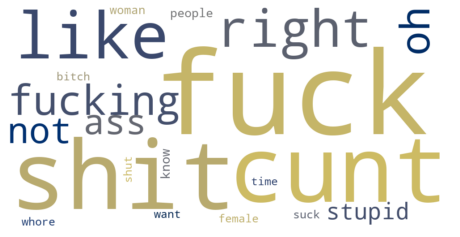

Wordcloud di ambito arts 

[(0.13120912, 'ass'), (0.13050094, 'people'), (0.09769059, 'like'), (0.089949206, 'ugly'), (0.08021999, 'black'), (0.06101393, 'photograph'), (0.05688131, 'shit'), (0.05142674, 'black_people'), (0.051274996, 'photographer'), (0.031724054, 'look_like'), (0.03157425, 'need'), (0.031429816, 'look'), (0.0311834, 'fucking'), (0.031095874, 'think'), (0.019804204, 'woman'), (0.0063048424, 'racist'), (0.005757191, 'design'), (0.003932602, 'know'), (0.0037113058, 'bitch'), (0.0036330975, 'art')] 

[('ass', 0.13120912), ('people', 0.13050094), ('like', 0.09769059), ('ugly', 0.089949206), ('black', 0.08021999), ('photograph', 0.06101393), ('shit', 0.05688131), ('black_people', 0.05142674), ('photographer', 0.051274996), ('look_like', 0.031724054), ('need', 0.03157425), ('look', 0.031429816), ('fucking', 0.0311834), ('think', 0.031095874), ('woman', 0.019804204), ('racist', 0.0063048424), ('design', 0.005757191), ('know', 0.003932602), ('bitch', 0.0037113058), ('art', 0.

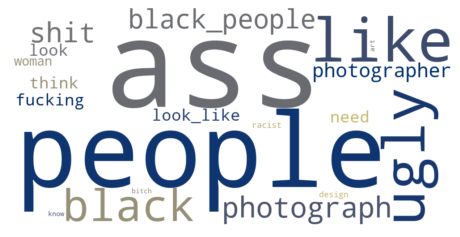

Wordcloud di ambito show 

[(0.12232863, 'cock'), (0.12207206, 'ugly'), (0.12200871, 'fat'), (0.09395619, 'like'), (0.078406505, 'good'), (0.07831243, 'big'), (0.078091115, 'face'), (0.0601528, 'look'), (0.03268469, 'cry'), (0.03243612, 'dick'), (0.028691972, 'love'), (0.026204955, 'work'), (0.02477124, 'suck'), (0.0086994, 'woman'), (0.005633384, 'cunt'), (0.0055739307, 'ass'), (0.0052017723, 'want'), (0.005161972, 'call'), (0.005119429, 'whore'), (0.005089136, 'rape')] 

[('cock', 0.12232863), ('ugly', 0.12207206), ('fat', 0.12200871), ('like', 0.09395619), ('good', 0.078406505), ('big', 0.07831243), ('face', 0.078091115), ('look', 0.0601528), ('cry', 0.03268469), ('dick', 0.03243612), ('love', 0.028691972), ('work', 0.026204955), ('suck', 0.02477124), ('woman', 0.0086994), ('cunt', 0.005633384), ('ass', 0.0055739307), ('want', 0.0052017723), ('call', 0.005161972), ('whore', 0.005119429), ('rape', 0.005089136)]


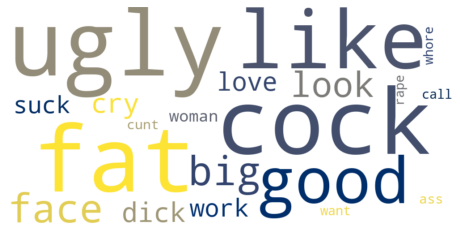

Wordcloud di ambito sport 

[(0.11431159, 'bitch'), (0.09882124, 'cunt'), (0.083782874, 'fuck'), (0.06861995, 'ass'), (0.065160885, 'woman'), (0.06295225, 'like'), (0.034987886, 'love'), (0.031262353, 'rape'), (0.031008499, 'man'), (0.027526908, 'girl'), (0.027485125, 'fucking'), (0.025615092, 'sexy'), (0.02374124, 'drunk'), (0.023529451, 'people'), (0.023405943, 'sport'), (0.020508489, 'not'), (0.020508213, 'think'), (0.020094223, 'bad'), (0.020059314, 'hopesolo'), (0.02000877, 'want')] 

[('bitch', 0.11431159), ('cunt', 0.09882124), ('fuck', 0.083782874), ('ass', 0.06861995), ('woman', 0.065160885), ('like', 0.06295225), ('love', 0.034987886), ('rape', 0.031262353), ('man', 0.031008499), ('girl', 0.027526908), ('fucking', 0.027485125), ('sexy', 0.025615092), ('drunk', 0.02374124), ('people', 0.023529451), ('sport', 0.023405943), ('not', 0.020508489), ('think', 0.020508213), ('bad', 0.020094223), ('hopesolo', 0.020059314), ('want', 0.02000877)]


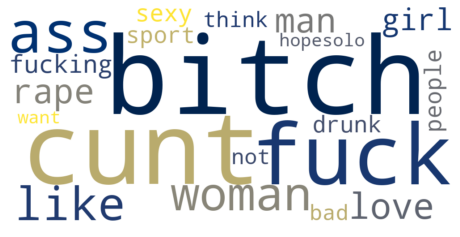

Wordcloud di ambito pol_act 

[(0.14444585, 'bitch'), (0.11008531, 'woman'), (0.09468666, 'whore'), (0.06005378, 'fuck'), (0.052615073, 'ugly'), (0.05194585, 'slut'), (0.048639026, 'cock'), (0.04826182, 'feminist'), (0.03594204, 'stupid'), (0.03293796, 'want'), (0.029353786, 'hole'), (0.026083214, 'man'), (0.026017543, 'mouth'), (0.02319809, 'evil'), (0.02011417, 'shit'), (0.019917239, 'let'), (0.018623313, 'nasty'), (0.017285842, 'old'), (0.01720432, 'stop'), (0.016569654, 'liberal')] 

[('bitch', 0.14444585), ('woman', 0.11008531), ('whore', 0.09468666), ('fuck', 0.06005378), ('ugly', 0.052615073), ('slut', 0.05194585), ('cock', 0.048639026), ('feminist', 0.04826182), ('stupid', 0.03594204), ('want', 0.03293796), ('hole', 0.029353786), ('man', 0.026083214), ('mouth', 0.026017543), ('evil', 0.02319809), ('shit', 0.02011417), ('let', 0.019917239), ('nasty', 0.018623313), ('old', 0.017285842), ('stop', 0.01720432), ('liberal', 0.016569654)]


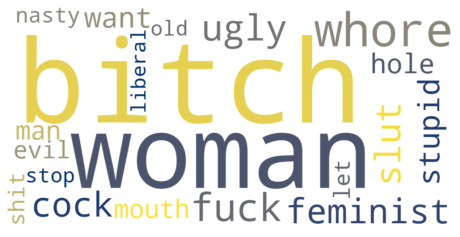

In [25]:
# More details about the interpretation of these topics can be found in the Section 4.3 of the report

for key, l in d_one_topic.items():
    print("Wordcloud di ambito", key, "\n")
    create_wordcloud(l)